# Pylops - seismic inversion

### Author: M.Ravasi

This notebook will focus on running post-stack inversion (for Acoustic Impedence) on GPUs using the Pylops-gpu framework

In [1]:
#!pip install pylops
!pip install git+https://git@github.com/equinor/pylops.git@master
!pip install git+https://git@github.com/equinor/pylops-gpu.git@master

  Cloning https://git@github.com/equinor/pylops.git (to revision master) to /tmp/pip-req-build-t0ohiw4u
  Running command git clone -q https://git@github.com/equinor/pylops.git /tmp/pip-req-build-t0ohiw4u
  Stored in directory: /tmp/pip-ephem-wheel-cache-sk_z24kv/wheels/20/30/e5/b89bfb2635eae9defa61ce159dec2e3ba62cd8e2f71ac057cb
Successfully built pylops
  Cloning https://git@github.com/equinor/pylops-gpu.git (to revision master) to /tmp/pip-req-build-ouxpr1u1
  Running command git clone -q https://git@github.com/equinor/pylops-gpu.git /tmp/pip-req-build-ouxpr1u1
  Stored in directory: /tmp/pip-ephem-wheel-cache-dj82e26s/wheels/c7/f0/0b/513e9be2dad0cbe2a900c0414a94bcae8778093383364aab9a
  Stored in directory: /root/.cache/pip/wheels/12/9c/1c/35f0a149f864e1b4d5f0711bf76745aebef1f306fc8ab9ec40
Successfully built pylops-gpu pytorch-complex-tensor


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import torch
import scipy as sp
import matplotlib.pyplot as plt
import pylops

from scipy.signal import filtfilt
from scipy.sparse.linalg import cg, lsqr
from pylops.utils import dottest
from pylops.utils.wavelets import ricker
from pylops import Diagonal, MatrixMult, FirstDerivative
from pylops.avo.poststack import PoststackLinearModelling

from pylops_gpu.utils.backend import device
from pylops_gpu.utils import dottest as gdottest
from pylops_gpu import FirstDerivative as gFirstDerivative
from pylops_gpu.avo.poststack import PoststackLinearModelling as gPoststackLinearModelling
from pylops_gpu.optimization import cg as gcg

Populating the interactive namespace from numpy and matplotlib


In [3]:
dev = device()
print('PyLops-gpu working on %s...' % dev)

torch.cuda.empty_cache()

PyLops-gpu working on cuda...


## Post-stack inversion - 1D

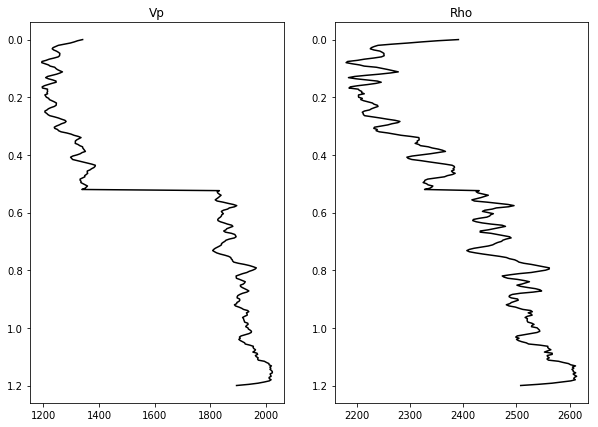

In [4]:
np.random.seed(0)

nt0 = 301
dt0 = 0.004

t0  = np.arange(nt0)*dt0
vp  = 1200 + np.arange(nt0) + filtfilt(np.ones(5)/5.,1,np.random.normal(0, 80, nt0))
rho = 1000 + vp             + filtfilt(np.ones(5)/5.,1,np.random.normal(0, 30, nt0))
vp[131:]+=500
rho[131:]+=100

m1d = np.log(vp*rho).flatten()
m1d = torch.from_numpy(m1d.astype(np.float32)).to(dev)

fig, axs = plt.subplots (1, 2, figsize=(10, 7))
axs[0].plot(vp,  t0, 'k')
axs[0].set_title('Vp')
axs[0].invert_yaxis()
axs[1].plot(rho, t0, 'k')
axs[1].set_title('Rho')
axs[1].invert_yaxis()

In [0]:
ntwav = 41
wav = ricker(t0[:ntwav//2+1], 15)[0]

In [10]:
# lop
PPop = gPoststackLinearModelling(torch.from_numpy(wav.astype(np.float32)).to(dev), nt0=nt0, 
                                device=dev)
gdottest(PPop, nt0, nt0, device=dev, verb=True, tol=1e-4)

# dense
PPop_dense = gPoststackLinearModelling(wav.astype(np.float32), nt0=nt0, explicit=True, 
                                      device=dev)
#gdottest(PPop_dense, nt0, nt0, device=dev, verb=True, tol=1e-4)

# pylops
PPop_pylops = PoststackLinearModelling(wav.astype(np.float32), nt0=nt0)
dottest(PPop_pylops, nt0, nt0, verb=True, tol=1e-4)

# pylops
PPop_dense_pylops = PoststackLinearModelling(wav.astype(np.float32), nt0=nt0, explicit=True)
dottest(PPop_dense_pylops, nt0, nt0, verb=True, tol=1e-4)

# data
d = PPop * m1d
#d_dense = PPop_dense * m1d
d_pylops = PPop_pylops * m1d.cpu().numpy()
d_dense_pylops = PPop_dense_pylops * m1d.cpu().numpy()

Dot test passed, v^T(Opu)=22.600166 - u^T(Op^Tv)=22.600166
Dot test passed, v^T(Opu)=10.888320 - u^T(Op^Tv)=10.888320
Dot test passed, v^T(Opu)=-16.093954 - u^T(Op^Tv)=-16.093954


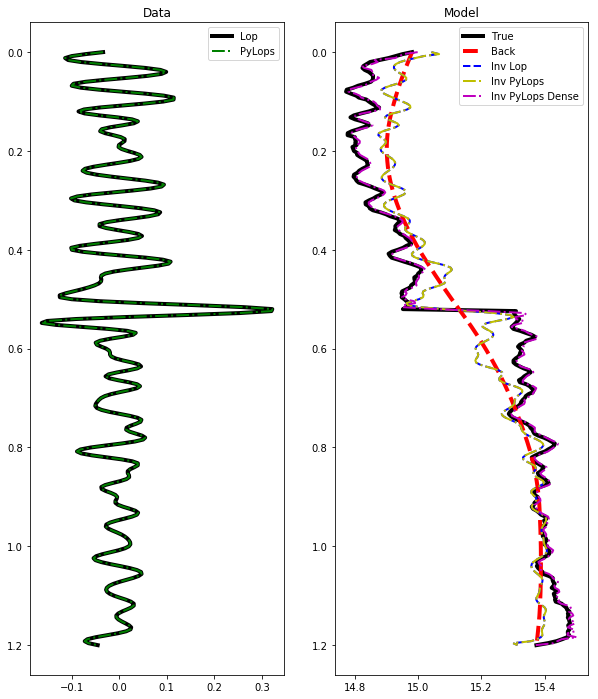

In [28]:
nsmooth = 100
m1dback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, m1d.cpu().numpy())
m1dback = torch.from_numpy(m1dback.astype(np.float32)).to(dev)

# solve lop
d0 = PPop * m1dback
dr = d - d0
minv = gcg(PPop.H * PPop, PPop.H * dr, niter=10)[0]
minv = m1dback + minv

# solve pylops lop
d0_pylops = PPop_pylops * m1dback.cpu().numpy()
dr_pylops = d.cpu().numpy() - d0.cpu().numpy()
minv_pylops = cg(PPop_pylops.H * PPop_pylops, PPop_pylops.H * dr_pylops, maxiter=10)[0]
minv_pylops = m1dback.cpu().numpy() + minv_pylops

# solve dense
#d0_dense = PPop*m1dback
#dr_dense = d_dense - d0_dense
#minv_dense = torch.solve(dr_dense.reshape(nt0, 1) , 
#                         PPop_dense.A.reshape(nt0, nt0) + 1e-4*torch.eye(nt0, dtype=torch.float32)).solution.flatten()
#minv_dense = m1dback + minv_dense

# solve dense pylops
d0_pylops_dense = PPop_dense_pylops*m1dback.cpu().numpy()
dr_pylops_dense = d_dense_pylops - d0_pylops_dense
minv_pylops_dense = lstsq(PPop_dense_pylops.A, dr_pylops_dense, rcond=1e-5)[0]
#minv_pylops_dense = lstsq(PPop_dense.A.cpu().numpy(), dr_pylops_dense.cpu().numpy(), rcond=1e-5)[0]
minv_pylops_dense = m1dback.cpu().numpy() + minv_pylops_dense

fig, axs = plt.subplots(1, 2, figsize=(10, 12))
axs[0].plot(d.cpu().numpy(), t0, 'k', lw=4, label='Lop')
#axs[0].plot(d_dense.cpu().numpy(), t0,'--r', lw=2, label='Dense')
axs[0].plot(d_pylops, t0,'-.g', lw=2, label='PyLops')
axs[0].set_title('Data')
axs[0].invert_yaxis()
axs[0].axis('tight')
axs[0].legend()
axs[1].plot(m1d.cpu().numpy(), t0, 'k', lw=4, label='True')
axs[1].plot(m1dback.cpu().numpy(), t0, '--r', lw=4, label='Back')
axs[1].plot(minv.cpu().numpy(), t0, '--b', lw=2, label='Inv Lop')
#axs[1].plot(minv_dense.cpu().numpy(), t0, '--g', lw=2, label='Inv Dense')
axs[1].plot(minv_pylops, t0, '-.y', lw=2, label='Inv PyLops')
axs[1].plot(minv_pylops_dense, t0, '-.m', lw=2, label='Inv PyLops Dense')
axs[1].set_title('Model')
axs[1].invert_yaxis()
axs[1].axis('tight')
axs[1].legend();

In [31]:
%timeit -r 3 -n 10 cg(PPop_pylops.H * PPop_pylops, PPop_pylops.H * dr_pylops, maxiter=50)[0]
%timeit -r 3 -n 10 gcg(PPop.H * PPop, PPop.H * dr, niter=50)[0]

10 loops, best of 3: 125 ms per loop
10 loops, best of 3: 225 ms per loop
